# Read files and settings from Recorder

In [1]:
% matplotlib inline
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

### Read an lvd file

In [2]:
file_path = '/Users/zeke/experiment/o19g19/Data/2018-12-04-0005/o19g19D-f00331.lvd' #one with a bit of song
file_path = '/Users/zeke/experiment/b5p5/Data/2018-12-06-0498/b5p5U-f02356.lvd' #one with settings I understand

import struct
from io import IOBase

### File utils
def open_file_decorator(open_mode='rb'):
    # Decorator to open a file with mode parameters, if a string is entered,
    # or work with the file pointer, if a IOBase is entered
    def open_file_wrapper_mode_set(func):
        # Decorator without parameters.
        # Note that open_mode is defined by the outside decorator function
        def wraped_func(file_or_path, *args, **kwargs):
            #print('file path {}'.format(file_or_path))
            if isinstance(file_or_path, str):
                with open(file_path, open_mode) as fid:
                    return_vaule = func(fid, *args, **kwargs)
            elif isinstance(file_or_path, IOBase):
                return_vaule =  func(file_or_path, *args, **kwargs)
            else:
                raise ValueError('function {} Received neither string, nor open file'.format(
                    func.__name__))
            return return_vaule
        return wraped_func
    return open_file_wrapper_mode_set

def get_file_size(fid: IOBase):
    fid.seek(0, 2)
    size_bytes = fid.tell()
    return size_bytes
    
@open_file_decorator(open_mode='rb') # Decorate so it can take a file_name
def read_header(fid: IOBase, style: str='chronic') -> tuple:
    if style is 'chronic':
        # the header for the 'chronic' mode is a set of 4 doubles:
        # [sampling_rate, n_channels, time_stamps, dynamic_range]
        # I got this from the ll_header function in matlab. 
        # It is big endian ('ieee-be' in matlab)
        # read 4 doubles
        # NOTE: there are more channels in the file than the chanels I could count in the
        # channel_info entry in the corresponding settings.txt files. 
        # I don't understand what I am missing, or why the hell someone would save channels into a 
        # binary file that contains data and not include those channels in the fucking settings file
        # that is supposed to describe the settings of the software that is making said file.
        # In any case, that is happening in extra channels that come after those described in the settings,
        # to the best of my knowledge. I am just ingoring them but carrying them.
        hdr_size = 32
        fid.seek(0)
        hdr_tuple = struct.unpack('>dddd', fid.read(hdr_size))
    else:
        raise NotimplementedError
    return hdr_tuple + (hdr_size, )

def set_data_type(file_format: int, style: str='chronic') -> str:
    # configure the data type of the recording
    if style is 'chronic':
        # int16, bigendian
        labview_type = '>h';
    else:
        raise NotImplementedError('Dont know datatpe other than chronic 1 yet')
    return labview_type

def dict_hdr(hdr_tuple):
    hdr_dict = {'hdr_size': hdr[4],
               'n_channels': int(hdr[1]),
               'sample_rate': hdr[0],
               'dynamic_range': hdr[3]}
    return hdr_dict

def read_file(file_path: str, style: str='chronic', file_format: int=1) -> tuple:
    data_type = set_data_type(file_format, style)
    elem_byte_size = struct.calcsize(data_type)
    
    with open(file_path, 'rb') as fid:
        hdr = read_header(file_path, style=style)
        file_size = get_file_size(fid)
        
        hdr_size_bytes = hdr[4]
        data_block_bytes = file_size - hdr_size_bytes
        
        n_channels = int(hdr[1])
        n_samples = data_block_bytes//(n_channels * elem_byte_size)
        
    data = np.memmap(file_path, dtype=data_type, mode='r', offset=hdr_size_bytes, shape=(n_samples, n_channels))
    hdr_dict = dict_hdr(hdr)
    return data, hdr_dict


## testing the functions
with open(file_path, 'rb') as fid: 
    hdr = read_header(fid)
    
data, hdr = read_file(file_path, style='chronic')

hdr

{'hdr_size': 32, 'n_channels': 3, 'sample_rate': 32000.0, 'dynamic_range': 5.0}

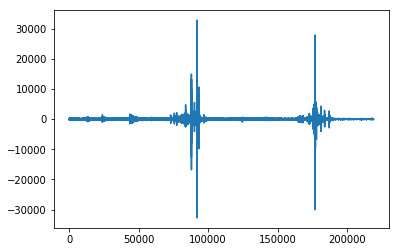

In [3]:
plt.plot(data[:,0])

## Read a settings file

In [4]:
# now for reading the settings:
import warnings

line_special_char_section = {
                     '##': 'activator',
                     '%%': 'detector',
                     '&&': 'effector',
                      }

def what_is_line(line: str, sect_char_dict: dict=line_special_char_section) -> str:
    section_keys = [v for (k, v) in sect_char_dict.items() if k in line]
    
    if len (section_keys) == 1:
        line_type = section_keys[0]
    elif len(section_keys) > 1:
        raise ValueError('More than one section key special char found in line {}'.format(line))

    elif line.strip() == '':
        line_type = 'blank'
    elif ':' in line.strip():
        line_type = 'key'
    elif len(section_keys) == 0:
        line_type = 'value'
    return line_type

def read_values(all_lines: list, values_tuple: tuple):
    line = all_lines.pop(0)
    line_type = what_is_line(line)
    if line_type is 'value':
        values_tuple += (line.strip(), )
        #print('line is value' + str(values_tuple))
        values_tuple = read_values(all_lines, values_tuple)
    elif line_type is 'blank':
        pass
        #print('line is blank')
        #print(values_tuple)
    else:
        raise ValueError('Weird line {} found while reading parameter values'.format(line))
    return values_tuple

def read_recorder_processor(all_lines: list, processor_dict: dict) -> dict:
    line = all_lines.pop(0)
    #print('reading processor line {}'.format(line))
    if '{' in line:
        try:
            key, val = line.strip().strip('\\').strip('{').split(':', 1)
            #print('read {}: {}'.format(key, val))
            processor_dict[key] = val
        except ValueError:
            warnings.warn('Failed to parse key: val reading recorder processor settings line {}'.format(line))
        processor_dict = read_recorder_processor(all_lines, processor_dict)
    elif '}' in line:
        #print('end of processor reading')
        pass
    else:
        warnings.warn('Unbecoming line while reading recorder processor settings line {}'.format(line))
        processor_dict = read_recorder_processor(all_lines, processor_dict)
    return processor_dict       
        
def process_top_level(all_lines: list, set_dict:dict):
    try:
        line = all_lines.pop(0)
        line_type = what_is_line(line)
        
    except IndexError as err:
        if len(all_lines) == 0:
            line_type = 'end'
        else:
            raise
        
    #print('{} is {}'.format(line, line_type))
    
    if line_type is 'key':
        #print('line is key: {}'.format(line))
        key = line.split(':')[0]
        values_tuple = read_values(all_lines, tuple())
        #print('values tuple is {}'.format(values_tuple))
        set_dict[key] = values_tuple
    
    elif line_type in line_special_char_section.values():
        #print('{} is {}'.format(line, line_type))
        #print('got to {}'.format(line_type))
        # make the entry if it's the first time this kind of key comes around
        if not line_type in set_dict:
            set_dict[line_type] = tuple()
        # Now read it and append it
        processor_dict = read_recorder_processor(all_lines, dict())
        #print('read processor {}'.format(processor_dict))
        set_dict[line_type] += (processor_dict, )
        
    
    elif line_type is 'end':
        print('Done reading')
        return set_dict
        
    set_dict = process_top_level(all_lines, set_dict)
    return set_dict

def make_chan_info_dict(settings_dict: dict) -> dict:
    ch_info_tuple = tuple()
    for ch_id, ch_info_string in zip(settings_dict['channels'], settings_dict['channel info']):
        ch_info_list = ch_info_string.split(',')
        ch_info_dict = {'chan_id': ch_id, 
                       'name': ch_info_list[1].strip(),
                        'save': ch_info_list[2].strip().split(' ')[1],
                       'gain': float(ch_info_list[3].strip().split(' ')[1]),
                       'rig': ch_info_list[0].strip()}
        ch_info_tuple += (ch_info_dict, )
    settings_dict['chan_info'] = ch_info_tuple
    return settings_dict

def read_settings_file(file_path: str) -> dict:
    with open(set_file_path, 'r') as fid: 
        file_lines = fid.readlines()
    settings_dict = process_top_level(file_lines, dict())
    return make_chan_info_dict(settings_dict)
    
#set_file_path = '/Users/zeke/experiment/o19g19/Settings/recorder_settings_20181207_1815.txt'
set_file_path = '/Users/zeke/experiment/b5p5/Settings/recorder_settings_20181206_1659.txt'
with open(set_file_path, 'r') as fid: 
    file_lines = fid.readlines()

settings_dict = read_settings_file(set_file_path)

settings_dict

Done reading


/Users/zeke/anaconda3/envs/mountain/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Failed to parse key: val reading recorder processor settings line {save level true\\



{'hostname': ('ZUFURIOUS',),
 'principal investigator': ('Corinna',),
 'birdname': ('b5p5',),
 'setup': ('E1',),
 'channels': ('PXI1Slot2/ai16', 'PXI1Slot2/ao2'),
 'buffersize': ('128',),
 'scanrate': ('32000.000000',),
 'dynamic range': ('5.000000',),
 'pre [s]': ('1.000000',),
 'post [s]': ('1.000000',),
 'timestamp': ('20181206165934.232',),
 'channel info': ('E1, microphone_e1, save true, gain 1.000000',
  'E1, PXI1Slot2/ao2, save true, gain 1.000000'),
 'detector': ({'class': ' detector_harmonics2',
   'name': ' detector_harmonics_e1',
   'AI indices': ' [0||]',
   'note': ' ',
   'meta file parameters': ' '},),
 'activator': ({'class': ' activator_threshold_history',
   'name': ' activator_threshold_history_e1',
   'message': ' number',
   'detector indices': ' [0||]',
   'note': ' length history - number of positive buffers: [20 5]',
   'meta file parameters': ' ',
   'mirror effector trigger': ' 1'},),
 'effector': ({'class': ' effector_overwrite_output',
   'name': ' effector_

In [5]:
settings_dict['chan_info']

({'chan_id': 'PXI1Slot2/ai16',
  'name': 'microphone_e1',
  'save': 'true',
  'gain': 1.0,
  'rig': 'E1'},
 {'chan_id': 'PXI1Slot2/ao2',
  'name': 'PXI1Slot2/ao2',
  'save': 'true',
  'gain': 1.0,
  'rig': 'E1'})

In [6]:
settings_dict['channel info']

('E1, microphone_e1, save true, gain 1.000000',
 'E1, PXI1Slot2/ao2, save true, gain 1.000000')

In [7]:
settings_dict = make_chan_info_dict(settings_dict)

In [8]:
settings_dict['chan_info']

({'chan_id': 'PXI1Slot2/ai16',
  'name': 'microphone_e1',
  'save': 'true',
  'gain': 1.0,
  'rig': 'E1'},
 {'chan_id': 'PXI1Slot2/ao2',
  'name': 'PXI1Slot2/ao2',
  'save': 'true',
  'gain': 1.0,
  'rig': 'E1'})

In [9]:
file_lines[57].strip().strip('\\').strip('{').split(':', 1)

['}']

In [10]:
file_lines[57].strip().strip('\\').strip('{').split(':')

['}']

In [11]:
a = tuple()

In [12]:
import warnings

In [13]:
warnings.warn('tu vieja')

/Users/zeke/anaconda3/envs/mountain/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: tu vieja
  """Entry point for launching an IPython kernel.


In [14]:
file_lines.pop(0)

'hostname:\n'

In [15]:
from pipefinch.recorder.core import setting
from pipefinch.recorder.core import data

In [18]:
from importlib import reload
reload(setting)
setting.read_settings_file(set_file_path)

Done reading


/Users/zeke/repos/pipefinch/pipefinch/recorder/core/setting.py:79: UserWarning: Failed to parse key: val reading recorder processor settings line {save level true\\

  else:


{'hostname': ('ZUFURIOUS',),
 'principal investigator': ('Corinna',),
 'birdname': ('b5p5',),
 'setup': ('E1',),
 'channels': ('PXI1Slot2/ai16', 'PXI1Slot2/ao2'),
 'buffersize': ('128',),
 'scanrate': ('32000.000000',),
 'dynamic range': ('5.000000',),
 'pre [s]': ('1.000000',),
 'post [s]': ('1.000000',),
 'timestamp': ('20181206165934.232',),
 'channel info': ('E1, microphone_e1, save true, gain 1.000000',
  'E1, PXI1Slot2/ao2, save true, gain 1.000000'),
 'detector': ({'class': ' detector_harmonics2',
   'name': ' detector_harmonics_e1',
   'AI indices': ' [0||]',
   'note': ' ',
   'meta file parameters': ' '},),
 'activator': ({'class': ' activator_threshold_history',
   'name': ' activator_threshold_history_e1',
   'message': ' number',
   'detector indices': ' [0||]',
   'note': ' length history - number of positive buffers: [20 5]',
   'meta file parameters': ' ',
   'mirror effector trigger': ' 1'},),
 'effector': ({'class': ' effector_overwrite_output',
   'name': ' effector_

In [ ]:
setting.read_settings_file(set_file_path)

In [19]:
data, hdr = data.read_file(file_path, style='chronic')

In [20]:
data.shape

(219008, 3)